# Load data

In [2]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'start_index', 'end_index', 'inheritance_state', 'deletion_type', 'score'])


In [4]:
# load deletions from a single chromosome
chrom = 22
deletions = []
with open('sherlock_phased/chr.%d.phased.txt' % chrom, 'r')  as f:
    for line in f:
        pieces = line.strip().split('\t')
        family_key = tuple([x.strip()[1:-1] for x in pieces[0][1:-1].split(',')])
        inheritance_state = [int(x) for x in pieces[2][1:-1].split()]
        if sum(inheritance_state[:4]) > 0:
            # This is a deletion
            deletions.append(Deletion(family_key, chrom, int(pieces[3]), int(pieces[4]), int(pieces[5]), int(pieces[6]), inheritance_state, inheritance_state.index(1), int(float(pieces[7]))))
            
# load families
family_to_individuals = dict()
family_to_indices = dict()
with open('sherlock_phased/chr.%d.families.txt' % chrom, 'r')  as f:
    for line in f:
        pieces = line.strip().split('\t')
        family_key = tuple([x.strip()[1:-1] for x in pieces[0][1:-1].split(',')])
        family_to_individuals[family_key] = [x.strip()[1:-1] for x in pieces[1][1:-1].split(',')]
        family_to_indices[family_key] = [int(x.strip()) for x in pieces[2][1:-1].split(',')]
print(len(family_to_individuals))

# remove artifact length 0 deletions
deletions = [d for d in deletions if d.start_pos != d.end_pos]
print(len(deletions))

862
1043


In [6]:
# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()
family_to_indices = dict()
for i in range(3, 23):
    with open('sherlock_phased/chr.%d.phased.txt' % i, 'r')  as f:
        for line in f:
            pieces = line.strip().split('\t')
            family_key = tuple([x.strip()[1:-1] for x in pieces[0][1:-1].split(',')])
            inheritance_state = [int(x) for x in pieces[2][1:-1].split()]
            if sum(inheritance_state[:4]) > 0:
                # This is a deletion
                deletions.append(Deletion(family_key, i, int(pieces[3]), int(pieces[4]), int(pieces[5]), int(pieces[6]), inheritance_state, inheritance_state.index(1), int(float(pieces[7]))))

    # load families
    with open('sherlock_phased/chr.%d.families.txt' % chrom, 'r')  as f:
        for line in f:
            pieces = line.strip().split('\t')
            family_key = tuple([x.strip()[1:-1] for x in pieces[0][1:-1].split(',')])
            individuals = [x.strip()[1:-1] for x in pieces[1][1:-1].split(',')]
            indices = [int(x.strip()) for x in pieces[2][1:-1].split(',')]
            if family_key in family_to_individuals and family_to_individuals[family_key] != individuals:
                print(family_to_individuals[family_key], individuals)
            family_to_individuals[family_key] = individuals
            if family_key in family_to_indices and family_to_indices[family_key] != indices:
                print(family_to_indices[family_key], indices)
            family_to_indices[family_key] = indices

# remove artifact length 0 deletions
deletions = [d for d in deletions if d.start_pos != d.end_pos]
print(len(deletions))

50511


In [7]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, _, disease_status = pieces[0:6]
            child_id_to_affected[child_id] = disease_status

# Distribution of deletions

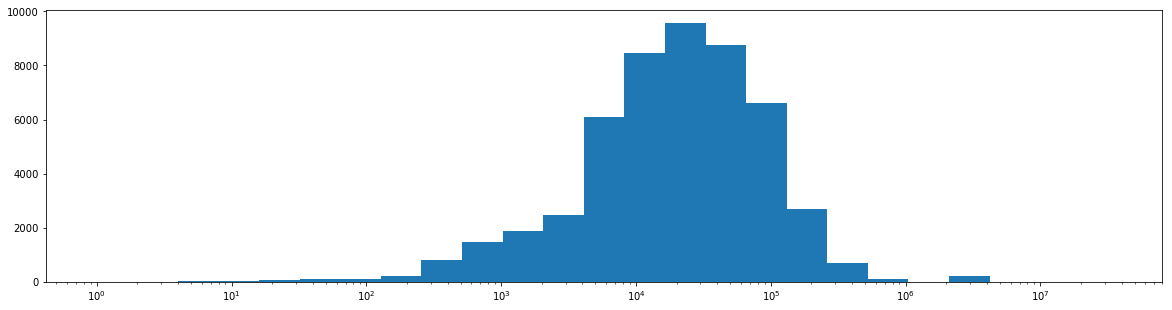

In [9]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
max_length = max([d.end_pos-d.start_pos for d in deletions]) 
plt.hist([d.end_pos-d.start_pos for d in deletions], bins=[pow(2, i) for i in range(math.ceil(math.log2(max_length))+1)])
plt.gca().set_xscale("log")
plt.show()

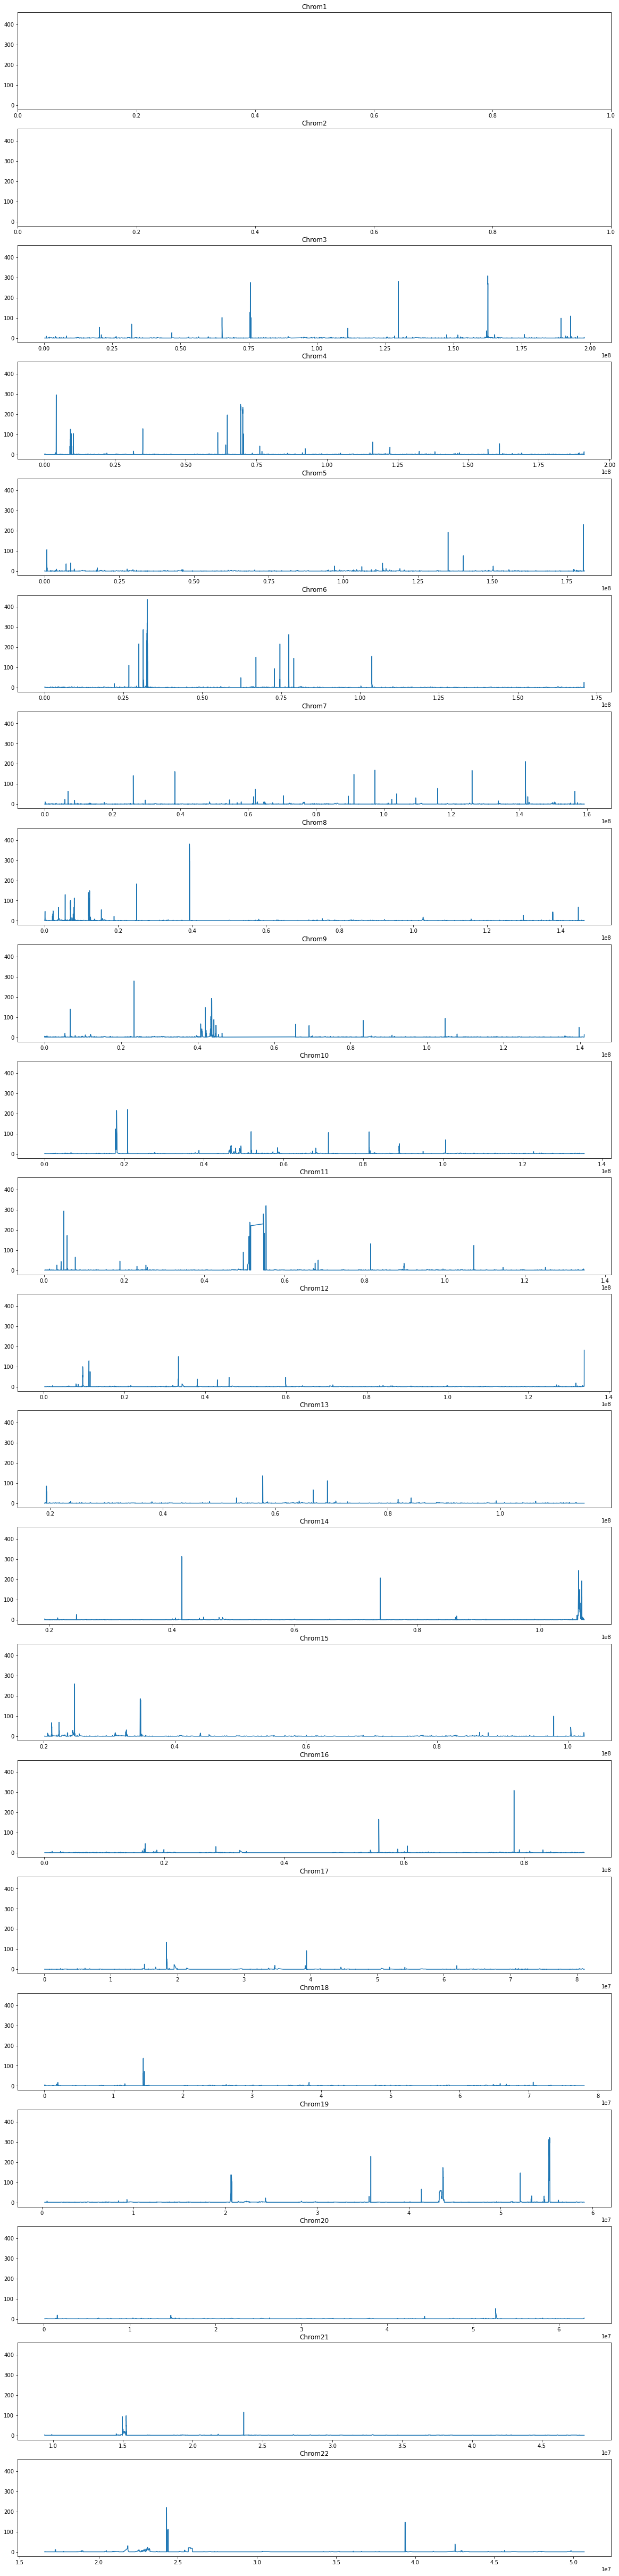

In [24]:
import numpy as np

# position of deletions
fig, ax = plt.subplots(22, 1, sharey=True, figsize=(20, 4*22))

for i in range(1, 23):
    ax[i-1].set_title('Chrom%d' % i)
    chrom_deletions = [d for d in deletions if d.chrom == i]
    if len(chrom_deletions) > 0:
        max_index = max([d.end_index for d in chrom_deletions])
        snp_positions = np.zeros((max_index+1,))
        deldist = np.zeros((max_index+1,))
        for d in chrom_deletions:
            deldist[d.start_index:(d.end_index+1)] += 1
            snp_positions[d.start_index] = d.start_pos
            snp_positions[d.end_index] = d.end_pos

        indices = np.where(snp_positions > 0)[0]
        ax[i-1].plot(snp_positions[indices], deldist[indices])

plt.show()

In [19]:
from scipy.stats import chi2_contingency

# mom vs dad
maternal_deletions = [d for d in deletions if np.sum(d.inheritance_state[:2]) > 0]
paternal_deletions = [d for d in deletions if np.sum(d.inheritance_state[2:4]) > 0]
print('maternal', len(maternal_deletions), 'paternal', len(paternal_deletions))

# inherited_deletions
mat_to_aut, mat_to_typ = 0, 0
mat_inh_aut, mat_inh_typ, mat_ni_aut, mat_ni_typ = 0, 0, 0, 0
for d in maternal_deletions:
    num_children = int((len(d.inheritance_state)-4)/2)
    for i, child_id in enumerate(family_to_individuals[d.family][2:]):
        is_affected = child_id_to_affected[child_id] == '2'
        is_inherited = d.inheritance_state[d.inheritance_state[4+2*i]] == 1
        
        if is_affected and is_inherited:
            mat_inh_aut += 1
            mat_to_aut += 1
        elif (not is_affected )and is_inherited:
            mat_inh_typ += 1
            mat_to_typ += 1
        elif is_affected and (not is_inherited):
            mat_ni_aut += 1
            mat_to_aut += 1
        elif (not is_affected) and (not is_inherited):
            mat_ni_typ += 1
            mat_to_typ += 1
print('')
print('maternal\tautism\ttypical\ttotal')
print('inherit\t\t%d\t%d\t%d' % (mat_inh_aut, mat_inh_typ, mat_inh_aut+mat_inh_typ))
print('no inherit\t%d\t%d\t%d' % (mat_ni_aut, mat_ni_typ, mat_ni_aut+mat_ni_typ))
print('total\t\t%d\t%d\t%d' % (mat_inh_aut+mat_ni_aut, mat_inh_typ+mat_ni_typ, mat_inh_aut+mat_inh_typ+mat_ni_aut+mat_ni_typ))
print('chisquare test', chi2_contingency([[mat_inh_aut, mat_inh_typ], [mat_ni_aut, mat_ni_typ]], correction=False)[:2])

pat_to_aut, pat_to_typ = 0, 0
pat_inh_aut, pat_inh_typ, pat_ni_aut, pat_ni_typ = 0, 0, 0, 0
for d in paternal_deletions:
    num_children = int((len(d.inheritance_state)-4)/2)
    for i, child_id in enumerate(family_to_individuals[d.family][2:]):
        is_affected = child_id_to_affected[child_id] == '2'
        is_inherited = d.inheritance_state[2+d.inheritance_state[5+2*i]] == 1
        
        if is_affected and is_inherited:
            pat_inh_aut += 1
            pat_to_aut += 1
        elif (not is_affected )and is_inherited:
            pat_inh_typ += 1
            pat_to_typ += 1
        elif is_affected and (not is_inherited):
            pat_ni_aut += 1
            pat_to_aut += 1
        elif (not is_affected) and (not is_inherited):
            pat_ni_typ += 1
            pat_to_typ += 1
print('')
print('paternal\tautism\ttypical\ttotal')
print('inherit\t\t%d\t%d\t%d' % (pat_inh_aut, pat_inh_typ, pat_inh_aut+pat_inh_typ))
print('no inherit\t%d\t%d\t%d' % (pat_ni_aut, pat_ni_typ, pat_ni_aut+pat_ni_typ))
print('total\t\t%d\t%d\t%d' % (pat_inh_aut+pat_ni_aut, pat_inh_typ+pat_ni_typ, pat_inh_aut+pat_inh_typ+pat_ni_aut+pat_ni_typ))
print('chisquare test', chi2_contingency([[pat_inh_aut, pat_inh_typ], [pat_ni_aut, pat_ni_typ]], correction=False)[:2])

print('')
print('both\t\tautism\ttypical\ttotal')
print('inherit\t\t%d\t%d\t%d' % (mat_inh_aut+pat_inh_aut, mat_inh_typ+pat_inh_typ, mat_inh_aut+mat_inh_typ+pat_inh_aut+pat_inh_typ))
print('no inherit\t%d\t%d\t%d' % (mat_ni_aut+pat_ni_aut, mat_ni_typ+pat_ni_typ, mat_ni_aut+mat_ni_typ+pat_ni_aut+pat_ni_typ))
print('total\t\t%d\t%d\t%d' % (mat_inh_aut+mat_ni_aut+pat_inh_aut+pat_ni_aut, mat_inh_typ+mat_ni_typ+pat_inh_typ+pat_ni_typ, mat_inh_aut+mat_inh_typ+mat_ni_aut+mat_ni_typ+pat_inh_aut+pat_inh_typ+pat_ni_aut+pat_ni_typ))
print('chisquare test', chi2_contingency([[mat_inh_aut+pat_inh_aut, mat_inh_typ+pat_inh_typ], [mat_ni_aut+pat_ni_aut, mat_ni_typ+pat_ni_typ]], correction=False)[:2])


maternal 27021 paternal 25067

maternal	autism	typical	total
inherit		36670	7163	43833
no inherit	19385	5531	24916
total		56055	12694	68749
chisquare test (361.98134287535669, 1.0426906802222183e-80)

paternal	autism	typical	total
inherit		33267	6727	39994
no inherit	17841	4961	22802
total		51108	11688	62796
chisquare test (233.65165167261887, 9.5280687730993386e-53)

both		autism	typical	total
inherit		69937	13890	83827
no inherit	37226	10492	47718
total		107163	24382	131545
chisquare test (591.08693176221061, 1.4537386301507291e-130)


In [32]:
from collections import Counter
# check double deletions
print(Counter([np.sum(d.inheritance_state[:4]) for d in deletions]))
print(Counter([tuple(d.inheritance_state[:4]) for d in deletions if np.sum(d.inheritance_state[:4])>1]))


Counter({1: 48917, 2: 1594})
Counter({(0, 1, 1, 0): 545, (1, 0, 0, 1): 540, (0, 1, 0, 1): 272, (1, 0, 1, 0): 220, (0, 0, 1, 1): 11, (1, 1, 0, 0): 6})


# Take a look at the deletions

In [240]:
from os import listdir

import numpy as np
from scipy import sparse

# load genotypes
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])

In [241]:
import gzip

# pull indices of snps
variant_file = 'split_gen/chr.%s.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions.append(int(pieces[1]))

In [242]:
whole_chrom = whole_chrom[:, snp_indices]
snp_positions = np.array(snp_positions)
m, n = whole_chrom.shape

In [ ]:
import random

# choose deletion
deletion = random.choice(deletions)
print(deletion)

# position of deletions
c = 10000
plt.figure(figsize=(20, 5))
plt.plot(snp_positions, np.convolve(deldist, np.ones((c,))/c, mode='same'))
plt.plot([deletion.start_pos], [0], marker='o', markersize=13, color="red")
plt.plot([deletion.end_pos], [0], marker='o', markersize=13, color="red")
plt.show()

[0, 0, 1, 0, 0, 0, 0, 1]


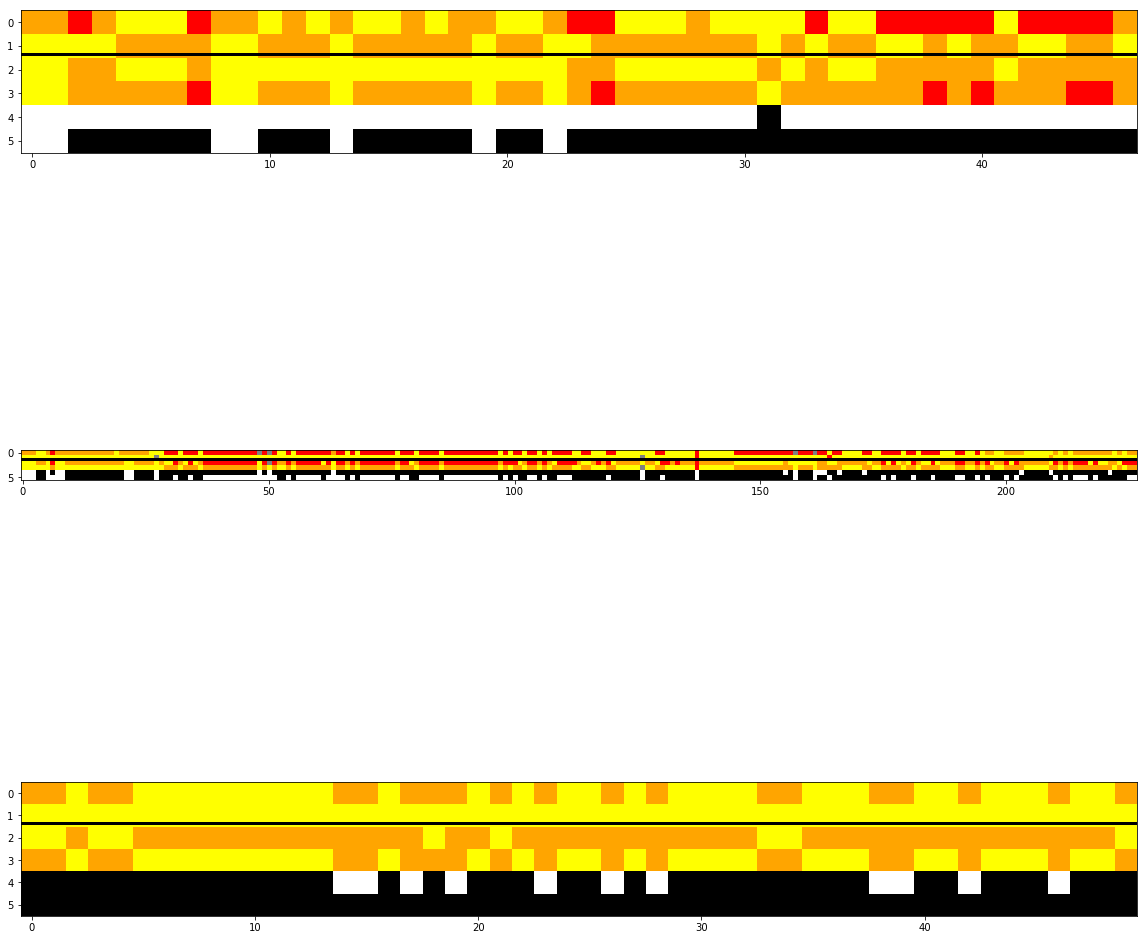

In [295]:
from itertools import product, chain
import matplotlib as mpl

# Find ok genotypes
print(deletion.inheritance_state)
family_size = int(len(deletion.inheritance_state)/2)
X = np.zeros((family_size, 4), dtype=int)
X[0, 0:2] = 1
X[1, 2:4] = 1
for i, s in enumerate(deletion.inheritance_state[4:]):
    if i % 2 == 0:
        X[2+int(i/2), s] = 1
    else:
        X[2+int((i-1)/2), 2+s] = 1
Y = np.array(list(product(*[[0, 1]]*4)), dtype=np.int8).T
ok_genotypes = set([tuple(z) for z in X.dot(Y).T])
ok_genotypes = set(chain.from_iterable([product(*[[y, -1] for y in x]) for x in ok_genotypes]))
#print('ok', sorted(ok_genotypes))

# Find ok deletion genotypes
valid_genotypes = np.zeros((16, family_size), dtype=np.int8)

# mom
if deletion.inheritance_state[0] == 0 and deletion.inheritance_state[1] == 0:
    valid_genotypes[:, 0] = Y[0, :] + Y[1, :]
elif deletion.inheritance_state[0] == 0:
    valid_genotypes[:, 0] = 2*Y[0, :]
elif deletion.inheritance_state[1] == 0:
    valid_genotypes[:, 0] = 2*Y[1, :]
else:
    valid_genotypes[:, 0] = -1

# dad
if deletion.inheritance_state[2] == 0 and deletion.inheritance_state[3] == 0:
    valid_genotypes[:, 1] = Y[2, :] + Y[3, :]
elif deletion.inheritance_state[2] == 0:
    valid_genotypes[:, 1] = 2*Y[2, :]
elif deletion.inheritance_state[3] == 0:
    valid_genotypes[:, 1] = 2*Y[3, :]
else:
    valid_genotypes[:, 1] = -1

# children
for index in range(family_size-2):
    mat, pat = deletion.inheritance_state[(4+(2*index)):(6+(2*index))]
    if deletion.inheritance_state[mat] == 0 and deletion.inheritance_state[2+pat] == 0:
        valid_genotypes[:, 2+index] = Y[mat, :] + Y[2+pat, :]
    elif deletion.inheritance_state[mat] == 0:
        valid_genotypes[:, 2+index] = 2*Y[mat, :]
    elif deletion.inheritance_state[2+pat] == 0:
        valid_genotypes[:, 2+index] = 2*Y[2+pat, :]
    else:
        valid_genotypes[:, 2+index] = -1
ok_deletion_genotypes = set([tuple(z) for z in valid_genotypes])
ok_deletion_genotypes = set(chain.from_iterable([product(*[[y, -1] for y in x]) for x in ok_deletion_genotypes]))
#print('ok deletion', sorted(ok_deletion_genotypes))
        
# Show deletion
plt.figure(figsize=(20, 20))

cmap = mpl.colors.ListedColormap(['gray', 'yellow', 'orange',  'red', 'black', 'white'])
norm = mpl.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)

plt.subplot(3, 1, 1)
segment = whole_chrom[family_to_indices[deletion.family], deletion.start_index-500:deletion.start_index].A
segment = segment[:, np.any(segment!=0, axis=0)]
plt.imshow(np.vstack((segment, 
                      [3+int(tuple(x) in ok_genotypes) for x in segment.T],
                     [3+int(tuple(x) in ok_deletion_genotypes) for x in segment.T])), vmin=-1, vmax=4, cmap=cmap, norm=norm, interpolation='none')
plt.axhline(y=1.33, linewidth=3, color='black')

plt.subplot(3, 1, 2)
segment = whole_chrom[family_to_indices[deletion.family], deletion.start_index:deletion.end_index+1].A
segment = segment[:, np.any(segment!=0, axis=0)]
plt.imshow(np.vstack((segment, 
                      [3+int(tuple(x) in ok_genotypes) for x in segment.T],
                     [3+int(tuple(x) in ok_deletion_genotypes) for x in segment.T])), vmin=-1, vmax=4, cmap=cmap, norm=norm, interpolation='none')
plt.axhline(y=1.33, linewidth=3, color='black')

plt.subplot(3, 1, 3)
segment = whole_chrom[family_to_indices[deletion.family], deletion.end_index+1:deletion.end_index+500].A
segment = segment[:, np.any(segment!=0, axis=0)]
plt.imshow(np.vstack((segment, 
                      [3+int(tuple(x) in ok_genotypes) for x in segment.T],
                     [3+int(tuple(x) in ok_deletion_genotypes) for x in segment.T])), vmin=-1, vmax=4, cmap=cmap, norm=norm, interpolation='none')
plt.axhline(y=1.33, linewidth=3, color='black')

plt.show()